| osteo_predict | 0.0	 | 1.0 | Total
| --- | --- | --- | --- |
| White | 18,512 (33.13%)	|18,218  (32.60%) |36,730 (65.72%)|
| Black| 8,596 (15.38%)|	8,627 (15.43%)|17,223 (30.82%)|
| Others |833 (1.491%)|	1,096 (1.96%)|	1,929 (3.45%)|
|Total| 27,941 (50%)|27,941 (50%)|	55,882 (100%)|

General: 

result in general

                  precision recall    f1-score support
        0.0       0.77      0.70      0.73     27941
        1.0       0.72      0.79      0.75     27941
avg / total       0.74      0.74      0.74     55882


ON AVG: confusion matrix for __white__: 

| osteo_predict | pos	 | neg |
| --- | --- | --- |
| reality_True | 2443.9 |  1080.5|
| reality_False | 788.8| 2679.8 |
 
white:               

                  precision recall    f1-score support
        0.0       0.76      0.69      0.72     18512
        1.0       0.71      0.77      0.74     18218
        avg/total 0.73      0.73      0.73     36730

***********
ON AVG: confusion matrix for __black__: 
 
| osteo_predict | pos	 | neg |
| --- | --- | --- |
| reality_True | 1185. |  452.5|
| reality_False| 320.| 1323.1 |
 
black:               

                  precision recall    f1-score  support
        0.0       0.79      0.72      0.75      8596
        1.0       0.75      0.80      0.77      8627
        avg/total 0.77      0.76      0.76     17223

 *************

ON AVG: confusion matrix for __others__: 

| osteo_predict | pos	 | neg |
| --- | --- | --- |
| reality_True | 93.1 |  65.1|
| reality_False| 30.4|178.|

others:  

                precision    recall  f1-score   support
        0.0       0.75      0.59      0.66       833
        1.0       0.73      0.85      0.79      1096
        avg/total 0.74      0.74      0.73      1929


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, cross_val_predict, cross_validate
import sklearn.linear_model as linear_model

from sklearn.cross_validation import cross_val_score
# from sklearn.cross_validation import KFold

from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
data_osteo = pd.read_csv('osteo_cleaning.csv')
print(data_osteo.shape)  

(55898, 191)


/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pd.crosstab(index=data_osteo["Race_combine"], columns=data_osteo["osteo_predict"], margins = True)

osteo_predict,0.0,1.0,All
Race_combine,,,
African American,8597,8629,17226
Caucasian,18515,18220,36735
Other,839,1098,1937
All,27951,27947,55898


In [4]:
pd.crosstab(index=data_osteo["Race_combine"], columns=data_osteo["osteo_predict"], margins = True)/data_osteo.shape[0]

osteo_predict,0.0,1.0,All
Race_combine,,,
African American,0.153798,0.154370,0.308168
Caucasian,0.331228,0.325951,0.657179
Other,0.015009,0.019643,0.034652
All,0.500036,0.499964,1.000000


In [4]:
# extract needed columns
osteo_extract = data_osteo.filter(['Strata','sex', 'Race_combine', 'Age_combine','osteo_predict', 'Hyponatremia_Prior',
    'Drug_antipsych_prior', 'Drug_Estrogens_prior' 'Drug_Glucocorticoids_prior', 
     'Drug_Nsaids_prior', 'Drug_Opiates_prior', 'Drug_Pp_inhibitors_prior' 'Drug_Progesterone_prior', 
    'Drug_Seizure_prior', 'Drug_Ssris_prior', 'Drug_Tc_antidepress_prior', 'Drug_Thiazide_prior', 
     'Chronic_Hyponatremia', 'Recent_Hyponatremia', 'Liver_Prior',
     'HeartDisease_Prior', 'PulmDisease_Prior', 'CNS_Disease_Prior', 
     'Malignancy_Prior', 'Alcohol_Prior', 'Tobacco_Prior',
     'Drug_Loop_Diuretic_Prior', 'Sodium_Avg_Ever', 'BMI_impute', 'osteo_predict'
     'Lowest_Recent_Hypo_Cat_edit', 'Median_Recent_Hypo_Cat_edit', 'Calcium_Avg_Ever']) 

osteo_extract['Calcium_Avg_Ever'] = osteo_extract['Calcium_Avg_Ever'].fillna(np.mean(osteo_extract['Calcium_Avg_Ever'])) 
osteo_extract['Sodium_Avg_Ever'] = osteo_extract['Sodium_Avg_Ever'].fillna(np.mean(osteo_extract['Sodium_Avg_Ever'])) 
osteo_extract.shape

(55898, 27)

In [6]:
#extract strata not in pair (maybe the missing pieces were drop during data cleaning)
missing_strata = osteo_extract.groupby('Strata').filter(lambda x: len(x) ==1)
missing_strata

,Strata,sex,Race_combine,Age_combine,osteo_predict,Hyponatremia_Prior,Drug_antipsych_prior,Drug_Nsaids_prior,Drug_Opiates_prior,Drug_Seizure_prior,...,PulmDisease_Prior,CNS_Disease_Prior,Malignancy_Prior,Alcohol_Prior,Tobacco_Prior,Drug_Loop_Diuretic_Prior,Sodium_Avg_Ever,BMI_impute,Median_Recent_Hypo_Cat_edit,Calcium_Avg_Ever
822,506,F,Caucasian,from_70_to_80,1.0,0,0,0,0,0,...,0,0,0,0,1,0,141.000000,0.000000,0.0,9.600000
845,519,F,Other,from_70_to_80,1.0,0,0,0,0,0,...,0,0,0,0,0,0,139.600000,0.000000,0.0,9.720000
9835,5430,F,African American,more_than_80,1.0,0,0,0,0,0,...,0,1,0,0,0,0,143.666667,0.000000,0.0,9.231579
10806,5955,F,African American,from_50_to_70,1.0,0,0,0,0,0,...,0,0,0,0,0,0,142.521739,0.000000,0.0,9.495652
16246,2538,F,Other,from_50_to_70,0.0,0,0,0,0,0,...,0,0,0,0,0,0,130.400000,26.070737,0.0,9.340000
18028,8097,F,Other,from_50_to_70,0.0,0,0,0,0,0,...,0,0,0,1,0,0,140.000000,25.270571,0.0,9.700000
18933,28669,F,African American,more_than_80,0.0,0,0,0,0,0,...,0,1,0,0,0,0,137.000000,0.000000,0.0,9.150000
20222,11085,F,Other,from_70_to_80,1.0,0,0,0,0,0,...,0,0,0,0,0,1,127.000000,0.000000,0.0,9.200000
27404,15038,F,Caucasian,more_than_80,0.0,0,0,0,1,0,...,0,0,0,0,0,1,143.884615,22.968750,0.0,7.229231
30557,16776,F,Caucasian,from_50_to_70,0.0,0,0,1,0,0,...,1,1,0,0,0,0,139.095238,22.176920,0.0,7.370476


In [7]:
osteo_extract_1 = osteo_extract.drop(missing_strata.index, axis = 0)
osteo_extract_1.shape

(55882, 27)

In [8]:
osteo_extract_1.describe()

,Strata,osteo_predict,Hyponatremia_Prior,Drug_antipsych_prior,Drug_Nsaids_prior,Drug_Opiates_prior,Drug_Seizure_prior,Drug_Ssris_prior,Drug_Tc_antidepress_prior,Drug_Thiazide_prior,...,PulmDisease_Prior,CNS_Disease_Prior,Malignancy_Prior,Alcohol_Prior,Tobacco_Prior,Drug_Loop_Diuretic_Prior,Sodium_Avg_Ever,BMI_impute,Median_Recent_Hypo_Cat_edit,Calcium_Avg_Ever
count,55882.000000,55882.000000,55882.000000,55882.000000,55882.00000,55882.000000,55882.000000,55882.000000,55882.000000,55882.000000,...,55882.000000,55882.000000,55882.000000,55882.000000,55882.000000,55882.000000,55882.000000,55882.000000,55882.0,55882.000000
mean,15267.969722,0.500000,0.156669,0.009806,0.04429,0.091371,0.002326,0.034501,0.007068,0.077055,...,0.192531,0.151748,0.018807,0.021814,0.162253,0.037883,139.270854,8.755697,0.0,8.744909
std,8798.919623,0.500004,0.363492,0.098541,0.20574,0.288139,0.048176,0.182514,0.083777,0.266681,...,0.394291,0.358780,0.135846,0.146077,0.368686,0.190916,3.175496,13.620751,0.0,1.328732
min,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.0,0.750000
25%,7645.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,137.846154,0.000000,0.0,8.509712
50%,15275.000000,0.500000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,139.666667,0.000000,0.0,8.883333
75%,22861.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,141.111111,22.271001,0.0,9.383333
max,30517.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,246.000000,96.150000,0.0,117.883333


In [24]:
pd.crosstab(index=osteo_extract_1["Race_combine"], columns=osteo_extract_1["osteo_predict"], margins = True)

osteo_predict,0.0,1.0,All
Race_combine,,,
African American,8596,8627,17223
Caucasian,18512,18218,36730
Other,833,1096,1929
All,27941,27941,55882


In [41]:
pd.crosstab(index=osteo_extract_1["Race_combine"], columns=osteo_extract_1["osteo_predict"], margins = True)/osteo_extract_1.shape[0]

osteo_predict,0.0,1.0,All
Race_combine,,,
African American,0.153824,0.154379,0.308203
Caucasian,0.331269,0.326008,0.657278
Other,0.014906,0.019613,0.034519
All,0.500000,0.500000,1.000000


### One-hot encoding

In [8]:
# Copy the original data
data_OHE = osteo_extract_1.copy()

numeric_subset = osteo_extract_1.select_dtypes('number')
categorical_subset = osteo_extract_1.select_dtypes('object')

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset) 

# Join the two dataframes using concat. Make sure to use axis = 1 to perform a column bind
data_OHE = pd.concat([numeric_subset, categorical_subset], axis = 1)

#y variable for OHE
y_OHE = data_OHE['osteo_predict']

print(data_OHE.shape)

(55882, 34)


In [26]:
data_OHE['Race_combine_Caucasian'].value_counts()

1    36730
0    19152
Name: Race_combine_Caucasian, dtype: int64

In [27]:
pd.crosstab(index=data_OHE["Race_combine_Caucasian"], columns=data_OHE["osteo_predict"], margins = True)

osteo_predict,0.0,1.0,All
Race_combine_Caucasian,,,
0,9429,9723,19152
1,18512,18218,36730
All,27941,27941,55882


### apply CV

In [9]:
#1st method: use FOR LOOP, then take the mean of accuracy of 10 folds
fold = KFold(10, shuffle = True, random_state = 1)

accuracy = []
precision = []
recall_accs = []
f1_score = []

strata = data_OHE['Strata']
all_preds = np.full(osteo_extract.shape[0], 100)

for i, (train_index, test_index) in enumerate(fold.split(strata)):
    
    train_index_strata = strata.iloc[train_index]
    test_index_strata = strata.iloc[test_index] 
    
    X_train = data_OHE.loc[data_OHE['Strata'].isin(train_index_strata)].drop('osteo_predict', axis = 1)
    X_test = data_OHE.loc[data_OHE['Strata'].isin(test_index_strata)].drop('osteo_predict', axis = 1)
    
    Xtest_reset_index = X_test.reset_index()['index']
     
    y_train = data_OHE.loc[data_OHE['Strata'].isin(train_index_strata)]['osteo_predict']
    y_test = data_OHE.loc[data_OHE['Strata'].isin(test_index_strata)]['osteo_predict']

    lr = linear_model.LogisticRegression() 
    fit = lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    all_preds[Xtest_reset_index] = y_pred
    
    acc= np.mean(y_pred == y_test) 
    accuracy.append(acc) 

    prec=precision_score(y_test, y_pred)
    precision.append(prec) 

    recall = recall_score(y_test, y_pred)
    recall_accs.append(recall) 

In [12]:
#remove extreme values in all_preds, since at beginning when created all_preds, default = 100, but we only have 1 or 0
all_pred = all_preds.copy()
index_del = np.where(all_pred == all_pred.max())
all_pred = np.delete(all_pred, index_del)

print('result in general')
print(classification_report(data_OHE['osteo_predict'], all_pred))

print('\nconfusion matrix on entire dataset')
print(confusion_matrix(data_OHE['osteo_predict'], all_pred)) 

result in general
             precision    recall  f1-score   support

        0.0       0.77      0.70      0.73     27941
        1.0       0.72      0.79      0.75     27941

avg / total       0.74      0.74      0.74     55882


confusion matrix on entire dataset
[[19535  8406]
 [ 5989 21952]]


In [13]:
#confusion matrix in general
fold = KFold(10,shuffle=True, random_state =1)
accuracy = []
precision = []
recall_accs = []
TP = []
TN = [] 
FP = []
FN = []
strata = data_OHE['Strata']
for i, (train_index, test_index) in enumerate(fold.split(strata)):
       
    train_index_strata = strata.iloc[train_index]
    test_index_strata = strata.iloc[test_index] 
    
    X_train = data_OHE.loc[data_OHE['Strata'].isin(train_index_strata)].drop('osteo_predict', axis = 1)
    X_test = data_OHE.loc[data_OHE['Strata'].isin(test_index_strata)].drop('osteo_predict', axis = 1)
     
    y_train = data_OHE.loc[data_OHE['Strata'].isin(train_index_strata)]['osteo_predict']
    y_test = data_OHE.loc[data_OHE['Strata'].isin(test_index_strata)]['osteo_predict']
  
    lr = linear_model.LogisticRegression() 
    fit = lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    TP.append(conf_matrix[0, 0]) 
    TN.append(conf_matrix[1,1])
    FP.append(conf_matrix[1,0])
    FN.append(conf_matrix[0,1])
tp_avg = np.mean(TP)
tn_avg = np.mean(TN)
fp_avg = np.mean(FP)
fn_avg = np.mean(FN)
print('TP: ', np.mean(TP))
print('TN: ', np.mean(TN))
print('FP: ', np.mean(FP))
print('FN: ', np.mean(FN))   

import numpy as np
np.array([[tp_avg, fn_avg], [fp_avg, tn_avg ]]) 

TP:  3716.4
TN:  4173.5
FP:  1137.0
FN:  1594.1


array([[3716.4, 1594.1],
       [1137. , 4173.5]])

In [30]:
#results in general
F1_general = 2 * (np.mean(precision) * np.mean(recall_accs)) / (np.mean(precision) + np.mean(recall_accs)) 


print('\n __accuracy__ on average: ', np.mean(accuracy))
print('\n __precision__ on average: ', np.mean(precision))
print('\n __recall__ on average: ', np.mean(recall_accs))
print('\n __f1__ on average: ', (F1_general))

#create a result table
n_cv = list(range(1, 11))
results_table = pd.DataFrame(index = range(len(n_cv),4), columns = ['CV_fold','accuracy at ith fold', 'precision at ith fold','recall at ith fold'])
results_table['CV_fold'] = n_cv

# add results to table
results_table['accuracy at ith fold'] = accuracy
results_table['precision at ith fold'] = precision
results_table['recall at ith fold'] = recall_accs
results_table


 __accuracy__ on average:  0.742850348301844

 __precision__ on average:  0.7236506884953114

 __recall__ on average:  0.785835335611265

 __f1__ on average:  0.7534621355578518


,CV_fold,accuracy at ith fold,precision at ith fold,recall at ith fold
0,1,0.741497,0.726195,0.775321
1,2,0.737813,0.716242,0.787691
2,3,0.742507,0.722461,0.787561
3,4,0.744992,0.725439,0.788360
4,5,0.746987,0.725926,0.793597
5,6,0.737615,0.718290,0.781880
6,7,0.746707,0.728318,0.786978
7,8,0.745682,0.728399,0.783515
8,9,0.744558,0.726032,0.785539
9,10,0.740146,0.719205,0.787913


Index(['Strata', 'Hyponatremia_Prior', 'Drug_antipsych_prior',
       'Drug_Nsaids_prior', 'Drug_Opiates_prior', 'Drug_Seizure_prior',
       'Drug_Ssris_prior', 'Drug_Tc_antidepress_prior', 'Drug_Thiazide_prior',
       'Chronic_Hyponatremia', 'Recent_Hyponatremia', 'Liver_Prior',
       'HeartDisease_Prior', 'PulmDisease_Prior', 'CNS_Disease_Prior',
       'Malignancy_Prior', 'Alcohol_Prior', 'Tobacco_Prior',
       'Drug_Loop_Diuretic_Prior', 'Sodium_Avg_Ever', 'BMI_impute',
       'Median_Recent_Hypo_Cat_edit', 'Calcium_Avg_Ever', 'sex_F', 'sex_M',
       'Race_combine_African American', 'Race_combine_Caucasian',
       'Race_combine_Other', 'Age_combine_from_30_to_50',
       'Age_combine_from_50_to_70', 'Age_combine_from_70_to_80',
       'Age_combine_less_than_30', 'Age_combine_more_than_80'],
      dtype='object')


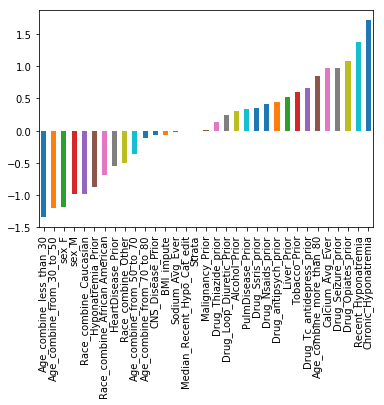

Chronic_Hyponatremia             1.716488e+00
Recent_Hyponatremia              1.370416e+00
Drug_Opiates_prior               1.080362e+00
Drug_Seizure_prior               9.667102e-01
Calcium_Avg_Ever                 9.619499e-01
Age_combine_more_than_80         8.400768e-01
Drug_Tc_antidepress_prior        6.533051e-01
Tobacco_Prior                    6.041722e-01
Liver_Prior                      5.216211e-01
Drug_antipsych_prior             4.432873e-01
Drug_Nsaids_prior                4.047989e-01
Drug_Ssris_prior                 3.532603e-01
PulmDisease_Prior                3.370396e-01
Alcohol_Prior                    3.035993e-01
Drug_Loop_Diuretic_Prior         2.347762e-01
Drug_Thiazide_prior              1.323251e-01
Malignancy_Prior                 1.514791e-02
Strata                           2.587179e-07
Median_Recent_Hypo_Cat_edit      0.000000e+00
Sodium_Avg_Ever                 -2.954240e-02
BMI_impute                      -6.431348e-02
CNS_Disease_Prior               -6

In [28]:
coefs = pd.Series(lr.coef_[0], index=X_train.columns)
print (X_train.columns) 
coefs = coefs.sort_values()
plt.subplot(1,1,1)
coefs.plot(kind="bar")
plt.show()
print (coefs.sort_values(ascending = False))

### calculate confusion matrix based on ages

In [33]:
#1st method: use FOR LOOP, then take the mean of accuracy of 10 folds
fold = KFold(10,shuffle=False, random_state = 1)
strata = data_OHE['Strata']
accuracy = []
precision = []
recall_accs = []

TP_white = []
TN_white = []
FP_white = []
FN_white = []

TP_black = []
TN_black = []
FP_black = []
FN_black = []

TP_other = []
TN_other = []
FP_other = []
FN_other = []

all_preds = np.full(osteo_extract.shape[0], 100)

for i, (train_index, test_index) in enumerate(fold.split(strata)):
                  
    train_index_strata = strata.iloc[train_index]
    test_index_strata = strata.iloc[test_index] 
    
    X_train = data_OHE.loc[data_OHE['Strata'].isin(train_index_strata)].drop('osteo_predict', axis = 1)
    X_test = data_OHE.loc[data_OHE['Strata'].isin(test_index_strata)].drop('osteo_predict', axis = 1)
     
    y_train = data_OHE.loc[data_OHE['Strata'].isin(train_index_strata)]['osteo_predict']
    y_test = data_OHE.loc[data_OHE['Strata'].isin(test_index_strata)]['osteo_predict']

    Xtest_reset_index = X_test.reset_index()['index']
     
    lr = linear_model.LogisticRegression() 
    fit = lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    all_preds[Xtest_reset_index] = y_pred
    
    acc= np.mean(y_pred == y_test) #each individual fold
    accuracy.append(acc)
    
    #combine X_test, y_test, y_pred into separate df to cal confusion matrix based on gender
    testing_data = pd.concat([X_test, y_test], axis=1)
    testing_data['y_pred'] = y_pred
#     print('\n age distribution in y_pred: \n',
#           pd.crosstab(index=X_test["sex_F"], columns=y_pred)/X_test.shape[0], '\n')
    

    white = testing_data.loc[testing_data['Race_combine_Caucasian'] == 1]
    black = testing_data.loc[testing_data['Race_combine_African American'] == 1]
    other = testing_data.loc[testing_data['Race_combine_Other'] == 1]
     
    conf_matrix_white = confusion_matrix(white['osteo_predict'], white['y_pred'])
    conf_matrix_black = confusion_matrix(black['osteo_predict'], black['y_pred'])
    conf_matrix_other = confusion_matrix(other['osteo_predict'], other['y_pred'])

    TP_white.append(conf_matrix_white[0, 0]) 
    TN_white.append(conf_matrix_white[1,1])
    FP_white.append(conf_matrix_white[1,0])
    FN_white.append(conf_matrix_white[0,1])

    TP_black.append(conf_matrix_black[0, 0]) 
    TN_black.append(conf_matrix_black[1,1])
    FP_black.append(conf_matrix_black[1,0])
    FN_black.append(conf_matrix_black[0,1])
    
    TP_other.append(conf_matrix_other[0, 0]) 
    TN_other.append(conf_matrix_other[1,1])
    FP_other.append(conf_matrix_other[1,0])
    FN_other.append(conf_matrix_other[0,1])

In [39]:
data_OHE['all_pred'] = all_pred
white = data_OHE.loc[data_OHE['Race_combine_Caucasian'] == 1]
print('white: ', classification_report(white['osteo_predict'], white['all_pred']))

black = data_OHE.loc[data_OHE['Race_combine_African American'] == 1]
print('black: ', classification_report(black['osteo_predict'], black['all_pred']))

other = data_OHE.loc[data_OHE['Race_combine_Other'] == 1]
print('others: ', classification_report(other['osteo_predict'], other['all_pred']))

white:               precision    recall  f1-score   support

        0.0       0.76      0.69      0.72     18512
        1.0       0.71      0.77      0.74     18218

avg / total       0.73      0.73      0.73     36730

black:               precision    recall  f1-score   support

        0.0       0.79      0.72      0.75      8596
        1.0       0.75      0.80      0.77      8627

avg / total       0.77      0.76      0.76     17223

others:               precision    recall  f1-score   support

        0.0       0.75      0.59      0.66       833
        1.0       0.73      0.85      0.79      1096

avg / total       0.74      0.74      0.73      1929



In [40]:
print('accuracy: ', np.mean(accuracy))
print('\nON AVG: confusion matrix for white: \n', np.array([[np.mean(TP_white), np.mean(FN_white)], 
                                                            [np.mean(FP_white), np.mean(TN_white)]]))
print('\nON AVG: confusion matrix for black: \n', np.array([[np.mean(TP_black), np.mean(FN_black)], 
                                                              [np.mean(FP_black), np.mean(TN_black)]]))
print('\nON AVG: confusion matrix for other: \n', np.array([[np.mean(TP_other), np.mean(FN_other)], 
                                                              [np.mean(FP_other), np.mean(TN_other)]]))

accuracy:  0.7427419919689817

ON AVG: confusion matrix for white: 
 [[2443.9 1080.5]
 [ 788.8 2679.8]]

ON AVG: confusion matrix for black: 
 [[1185.   452.5]
 [ 320.  1323.1]]

ON AVG: confusion matrix for other: 
 [[ 93.1  65.1]
 [ 30.4 178. ]]


### Random Forest

In [10]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#1st method: use FOR LOOP, then take the mean of accuracy of 10 folds
fold = KFold(10, shuffle = True, random_state = 1)

accuracy = []
precision = []
recall_accs = []
f1_score = []

strata = data_OHE['Strata']
all_preds = np.full(osteo_extract.shape[0], 100)

for i, (train_index, test_index) in enumerate(fold.split(strata)):
    
    train_index_strata = strata.iloc[train_index]
    test_index_strata = strata.iloc[test_index] 
    
    X_train = data_OHE.loc[data_OHE['Strata'].isin(train_index_strata)].drop('osteo_predict', axis = 1)
    X_test = data_OHE.loc[data_OHE['Strata'].isin(test_index_strata)].drop('osteo_predict', axis = 1)
    
    Xtest_reset_index = X_test.reset_index()['index']
     
    y_train = data_OHE.loc[data_OHE['Strata'].isin(train_index_strata)]['osteo_predict']
    y_test = data_OHE.loc[data_OHE['Strata'].isin(test_index_strata)]['osteo_predict']
    
 
    clf=RandomForestClassifier(n_estimators=100)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)

    all_preds[Xtest_reset_index] = y_pred
    
    acc= np.mean(y_pred == y_test) 
    accuracy.append(acc) 

    prec=precision_score(y_test, y_pred)
    precision.append(prec) 

    recall = recall_score(y_test, y_pred)
    recall_accs.append(recall) 

In [11]:
#remove extreme values in all_preds, since at beginning when created all_preds, default = 100, but we only have 1 or 0
all_pred = all_preds.copy()
index_del = np.where(all_pred == all_pred.max())
all_pred = np.delete(all_pred, index_del)

print('result in general')
print(classification_report(data_OHE['osteo_predict'], all_pred))

print('\nconfusion matrix on entire dataset')
print(confusion_matrix(data_OHE['osteo_predict'], all_pred)) 

result in general
             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98     27941
        1.0       0.98      0.98      0.98     27941

avg / total       0.98      0.98      0.98     55882


confusion matrix on entire dataset
[[27313   628]
 [  647 27294]]


In [12]:
#results in general
F1_general = 2 * (np.mean(precision) * np.mean(recall_accs)) / (np.mean(precision) + np.mean(recall_accs)) 

print('\n __accuracy__ on average: ', np.mean(accuracy))
print('\n __precision__ on average: ', np.mean(precision))
print('\n __recall__ on average: ', np.mean(recall_accs))
print('\n __f1__ on average: ', (F1_general))

#create a result table
n_cv = list(range(1, 11))
results_table = pd.DataFrame(index = range(len(n_cv),4), columns = ['CV_fold','accuracy at ith fold', 'precision at ith fold','recall at ith fold'])
results_table['CV_fold'] = n_cv

# add results to table
results_table['accuracy at ith fold'] = accuracy
results_table['precision at ith fold'] = precision
results_table['recall at ith fold'] = recall_accs
results_table


 __accuracy__ on average:  0.9879655909786346

 __precision__ on average:  0.9881129560797703

 __recall__ on average:  0.9878147702103535

 __f1__ on average:  0.9879638406455515


,CV_fold,accuracy at ith fold,precision at ith fold,recall at ith fold
0,1,0.986961,0.987330,0.986584
1,2,0.987201,0.987752,0.986637
2,3,0.988010,0.988376,0.987636
3,4,0.988001,0.988093,0.987906
4,5,0.987853,0.987761,0.987947
5,6,0.987757,0.987573,0.987945
6,7,0.988333,0.987599,0.989085
7,8,0.989110,0.989110,0.989110
8,9,0.987034,0.987680,0.986371
9,10,0.989396,0.989855,0.988926


In [13]:
#confusion matrix in general
fold = KFold(10,shuffle=True, random_state =1)
accuracy = []
precision = []
recall_accs = []
TP = []
TN = [] 
FP = []
FN = []
strata = data_OHE['Strata']
for i, (train_index, test_index) in enumerate(fold.split(strata)):
       
    train_index_strata = strata.iloc[train_index]
    test_index_strata = strata.iloc[test_index] 
    
    X_train = data_OHE.loc[data_OHE['Strata'].isin(train_index_strata)].drop('osteo_predict', axis = 1)
    X_test = data_OHE.loc[data_OHE['Strata'].isin(test_index_strata)].drop('osteo_predict', axis = 1)
     
    y_train = data_OHE.loc[data_OHE['Strata'].isin(train_index_strata)]['osteo_predict']
    y_test = data_OHE.loc[data_OHE['Strata'].isin(test_index_strata)]['osteo_predict']
  
    clf=RandomForestClassifier(n_estimators=100)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    TP.append(conf_matrix[0, 0]) 
    TN.append(conf_matrix[1,1])
    FP.append(conf_matrix[1,0])
    FN.append(conf_matrix[0,1])
tp_avg = np.mean(TP)
tn_avg = np.mean(TN)
fp_avg = np.mean(FP)
fn_avg = np.mean(FN)
print('TP: ', np.mean(TP))
print('TN: ', np.mean(TN))
print('FP: ', np.mean(FP))
print('FN: ', np.mean(FN))   

import numpy as np
np.array([[tp_avg, fn_avg], [fp_avg, tn_avg ]]) 

TP:  5246.2
TN:  5244.9
FP:  65.6
FN:  64.3


array([[5246.2,   64.3],
       [  65.6, 5244.9]])

### SVM

In [ ]:
from sklearn import svm
fold = KFold(10, shuffle = True, random_state = 1)

accuracy = []
precision = []
recall_accs = []

strata = data_OHE['Strata']
all_preds = np.full(osteo_extract.shape[0], 100)

for i, (train_index, test_index) in enumerate(fold.split(strata)):
    
    train_index_strata = strata.iloc[train_index]
    test_index_strata = strata.iloc[test_index] 
    
    X_train = data_OHE.loc[data_OHE['Strata'].isin(train_index_strata)].drop('osteo_predict', axis = 1)
    X_test = data_OHE.loc[data_OHE['Strata'].isin(test_index_strata)].drop('osteo_predict', axis = 1)
    
    Xtest_reset_index = X_test.reset_index()['index']
     
    y_train = data_OHE.loc[data_OHE['Strata'].isin(train_index_strata)]['osteo_predict']
    y_test = data_OHE.loc[data_OHE['Strata'].isin(test_index_strata)]['osteo_predict']
    
    clf = svm.SVC(kernel='linear') # Linear Kernel
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)

    all_preds[Xtest_reset_index] = y_pred
    
    acc= np.mean(y_pred == y_test) 
    accuracy.append(acc) 

    prec=precision_score(y_test, y_pred)
    precision.append(prec) 

    recall = recall_score(y_test, y_pred)
    recall_accs.append(recall)  

In [ ]:
#remove extreme values in all_preds, since at beginning when created all_preds, default = 100, but we only have 1 or 0
all_pred = all_preds.copy()
index_del = np.where(all_pred == all_pred.max())
all_pred = np.delete(all_pred, index_del)

print('result in general')
print(classification_report(data_OHE['osteo_predict'], all_pred))

print('\nconfusion matrix on entire dataset')
print(confusion_matrix(data_OHE['osteo_predict'], all_pred)) 

In [ ]:
#results in general
F1_general = 2 * (np.mean(precision) * np.mean(recall_accs)) / (np.mean(precision) + np.mean(recall_accs)) 

print('\n __accuracy__ on average: ', np.mean(accuracy))
print('\n __precision__ on average: ', np.mean(precision))
print('\n __recall__ on average: ', np.mean(recall_accs))
print('\n __f1__ on average: ', (F1_general))

#create a result table
n_cv = list(range(1, 11))
results_table = pd.DataFrame(index = range(len(n_cv),4), columns = ['CV_fold','accuracy at ith fold', 'precision at ith fold','recall at ith fold'])
results_table['CV_fold'] = n_cv

# add results to table
results_table['accuracy at ith fold'] = accuracy
results_table['precision at ith fold'] = precision
results_table['recall at ith fold'] = recall_accs
results_table